In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

# Загружаем данные Fashion MNIST
(fashion_train_data, _), (fashion_test_data, _) = fashion_mnist.load_data()

# Нормализация данных Fashion MNIST
fashion_train_data = fashion_train_data.astype('float32') / 255.
fashion_test_data = fashion_test_data.astype('float32') / 255.

# Загружаем данные MNIST
(nums_train_data, _), (nums_test_data, _) = mnist.load_data()

# Нормализация данных MNIST
nums_train_data = nums_train_data.astype('float32') / 255
nums_test_data = nums_test_data.astype('float32') / 255

# Объединение тестовых данных Fashion MNIST и MNIST в одну переменную
test_data = np.concatenate((fashion_test_data, nums_test_data), axis=0)

# Создание меток
fashion_labels = np.ones(fashion_test_data.shape[0], dtype=bool)  # True для fashion_test_data
nums_labels = np.zeros(nums_test_data.shape[0], dtype=bool)        # False для nums_test_data
test_labels = np.concatenate((fashion_labels, nums_labels), axis=0)

# Перемешивание данных и меток
indices = np.arange(test_data.shape[0])
np.random.shuffle(indices)

test_data = test_data[indices]
test_labels = test_labels[indices]

print(fashion_train_data.shape, len(test_data), len(test_labels))


(60000, 28, 28) 20000 20000


Теперь напишем AnomalyDetector

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.1007 - val_loss: 0.0475
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0275 - val_loss: 0.0397
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0224 - val_loss: 0.0367
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0200 - val_loss: 0.0338
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0185 - val_loss: 0.0323
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0174 - val_loss: 0.0313
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0170 - val_loss: 0.0305
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0159 - val_loss: 0.0292
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0153 - val_loss: 0.0287
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0149 - val_loss: 0.0285
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0145 - val_loss: 0.0280
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 

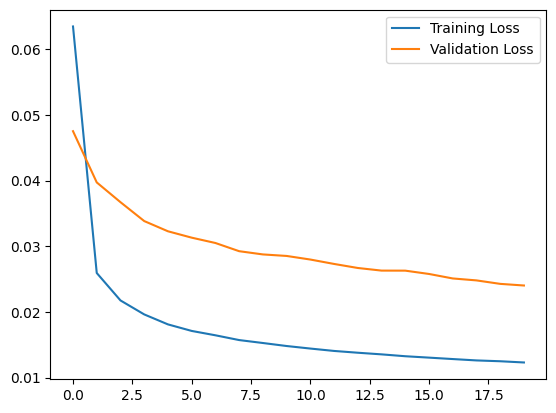

In [33]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
        ])


        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(7 * 7 * 32, activation='relu'),  # Восстановление до 7x7x32
            tf.keras.layers.Reshape((7, 7, 32)),  # Изменение формы
            tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),  # 7x7 -> 7x7
            tf.keras.layers.UpSampling2D((2, 2)),  # 7x7 -> 14x14
            tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),  # 14x14 -> 14x14
            tf.keras.layers.UpSampling2D((2, 2)),  # 14x14 -> 28x28
            tf.keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')  # 28x28 -> 28x28
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(fashion_train_data, fashion_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


Detect anomalys

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


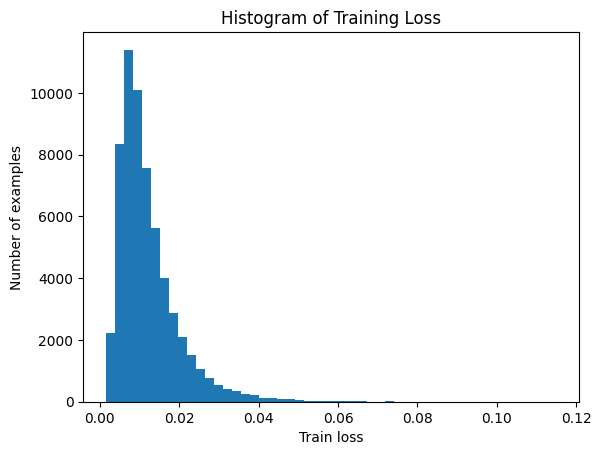

In [34]:
reconstructions = autoencoder.predict(fashion_train_data)

if fashion_train_data.ndim == 3:
    fashion_train_data = np.expand_dims(fashion_train_data, axis=-1)  # Преобразуем в (60000, 28, 28, 1)


# Вычисляем среднюю абсолютную ошибку
train_loss = tf.keras.losses.mse(reconstructions.flatten().reshape((reconstructions.shape[0], -1)), fashion_train_data.flatten().reshape((reconstructions.shape[0], -1)))

# Строим гистограмму
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.title("Histogram of Training Loss")
plt.show()

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.020103075


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


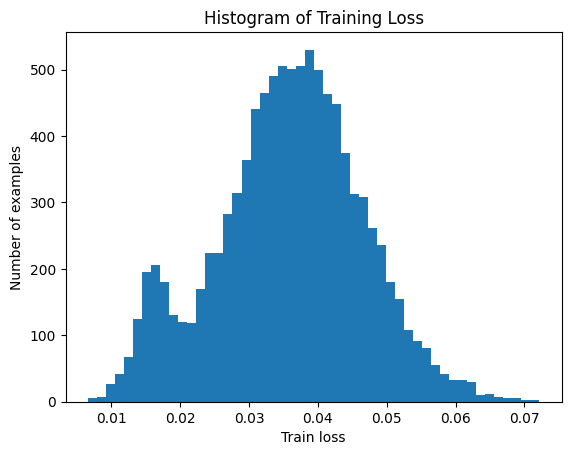

In [36]:
reconstructions = autoencoder.predict(nums_test_data)

if nums_test_data.ndim == 3:
    nums_test_data = np.expand_dims(nums_test_data, axis=-1)  # Преобразуем в (60000, 28, 28, 1)

# Вычисляем среднюю абсолютную ошибку
train_loss = tf.keras.losses.mse(reconstructions.flatten().reshape((reconstructions.shape[0], -1)), nums_test_data.flatten().reshape((reconstructions.shape[0], -1)))

# Строим гистограмму
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.title("Histogram of Training Loss")
plt.show()

In [37]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(np.array(reconstructions).flatten().reshape((reconstructions.shape[0], -1)), np.array(data).flatten().reshape((reconstructions.shape[0], -1))) 
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [38]:
td = tf.convert_to_tensor(test_data)
preds = predict(autoencoder, td, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8854
Precision = 0.896013152486642
Recall = 0.872
